In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def analyze_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

df = pd.read_csv('cleaned_trump_tweets.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df['content'] = df['content'].astype(str)

df['compound'], df['negative'], df['neutral'], df['positive'] = zip(*df['content'].apply(analyze_sentiment))
df

,content,compound,negative,neutral,positive
0,sure tune watch donald trump late night david ...,0.4767,0.00,0.745,0.255
1,donald trump appearing view tomorrow morning d...,0.7506,0.00,0.652,0.348
2,donald trump reads top ten financial tips late...,0.5719,0.00,0.680,0.320
3,new blog post celebrity apprentice finale less...,0.0000,0.00,1.000,0.000
4,persona never wallflower rather build walls cl...,0.0000,0.00,1.000,0.000
...,...,...,...,...,...
43347,joe biden total failure government bungled eve...,-0.5106,0.32,0.680,0.000
43348,interviewed seanhannity tonight 9 00 p enjoy,0.4939,0.00,0.556,0.444
43349,pic twitter com 3lm1spbu8x,0.0000,0.00,1.000,0.000
43350,pic twitter com vpce5maduz,0.0000,0.00,1.000,0.000


In [8]:
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['compound'].apply(categorize_sentiment)

df.to_csv('trump_tweets_with_sentiment.csv', index=False)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)
value_counts = df['sentiment'].value_counts()
print(value_counts)

df


sentiment
positive    25484
negative    10382
neutral      7486
Name: count, dtype: int64


,content,compound,negative,neutral,positive,sentiment,sentiment_numeric
0,sure tune watch donald trump late night david ...,0.4767,0.00,0.745,0.255,positive,2
1,donald trump appearing view tomorrow morning d...,0.7506,0.00,0.652,0.348,positive,2
2,donald trump reads top ten financial tips late...,0.5719,0.00,0.680,0.320,positive,2
3,new blog post celebrity apprentice finale less...,0.0000,0.00,1.000,0.000,neutral,1
4,persona never wallflower rather build walls cl...,0.0000,0.00,1.000,0.000,neutral,1
...,...,...,...,...,...,...,...
43347,joe biden total failure government bungled eve...,-0.5106,0.32,0.680,0.000,negative,0
43348,interviewed seanhannity tonight 9 00 p enjoy,0.4939,0.00,0.556,0.444,positive,2
43349,pic twitter com 3lm1spbu8x,0.0000,0.00,1.000,0.000,neutral,1
43350,pic twitter com vpce5maduz,0.0000,0.00,1.000,0.000,neutral,1


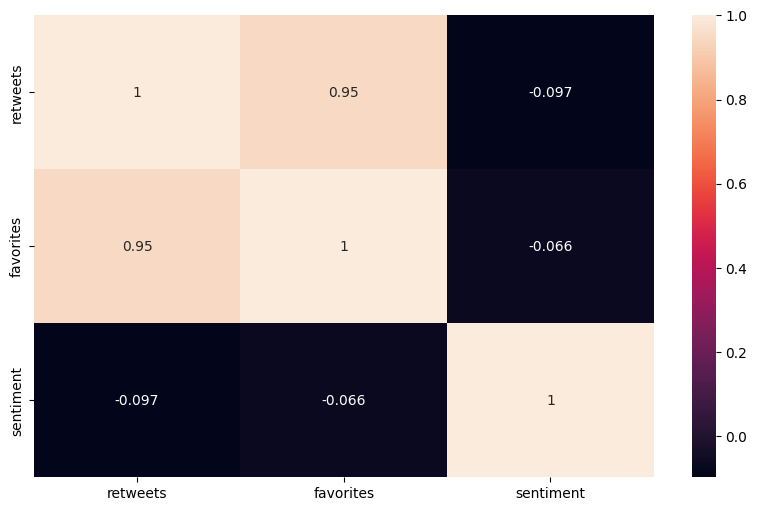

In [11]:
prev_df=pd.read_csv('realdonaldtrump.csv')
retweets=prev_df['retweets']
favorites=prev_df['favorites']
sentiment_numeric=df['sentiment_numeric']

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame({'retweets': retweets, 'favorites': favorites, 'sentiment': sentiment_numeric}).corr(), annot=True)
plt.show()


In [49]:
X=df[['negative', 'neutral', 'positive']]
y=df['sentiment_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model=RandomForestClassifier()
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2104
           1       0.98      0.97      0.97      1567
           2       0.99      0.99      0.99      5000

    accuracy                           0.99      8671
   macro avg       0.98      0.98      0.98      8671
weighted avg       0.99      0.99      0.99      8671



In [50]:
explainer=shap.Explainer(model.predict, X_test)
shap_values=explainer(X_test)


ExactExplainer explainer: 8672it [07:32, 18.73it/s]                          


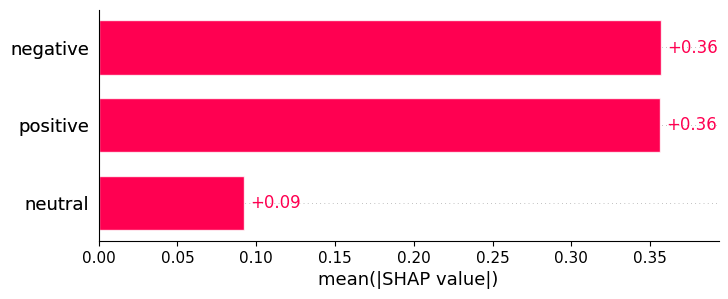

In [51]:
shap.plots.bar(shap_values)


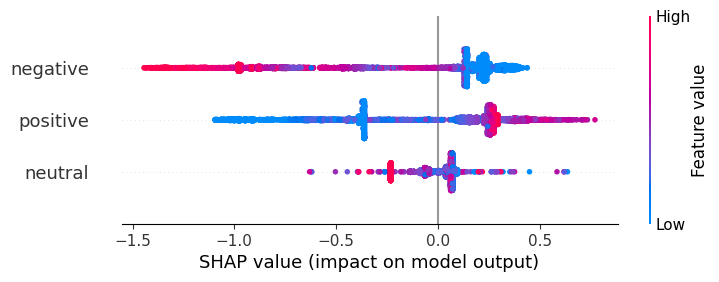

In [52]:
shap.plots.beeswarm(shap_values)


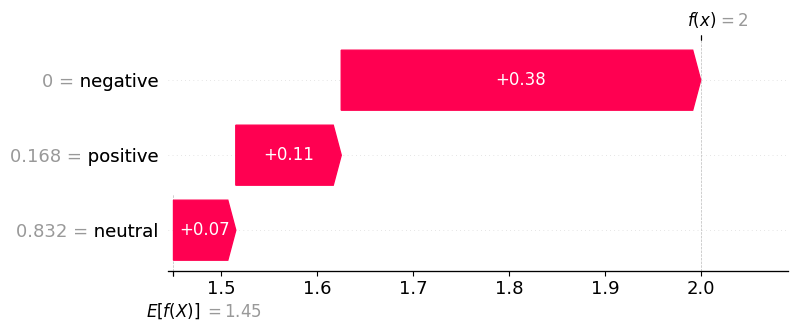

In [53]:
shap.plots.waterfall(shap_values[0])
